In [142]:
import pandas as pd

In [143]:
DATA_DIR_PATH = "../.data/measurements-public/"
LABEL = "f18999999t20371443s366"

In [144]:
path = DATA_DIR_PATH + LABEL + ".csv"
df = pd.read_csv(path)
df_wide = df.pivot(index='block_num', columns='run_type', values='exe_time').reset_index()
# For any duplicated block_num, we take the mean of the values 
df_wide = df_wide.groupby('block_num').mean().reset_index()
print(f"Found {len(df_wide)} pairs with min-block-num: {df_wide['block_num'].min()} and max-block-num: {df_wide['block_num'].max()}")

Found 366 pairs with min-block-num: 19007540 and max-block-num: 20366976


## Paired t-test

In [145]:
import scipy.stats as stats
import numpy as np

def perform_t_test(sample_new, sample_old, alpha=0.05):
    t_stat, p_value = stats.ttest_rel(sample_new, sample_old)

    print(f"mean-diff: {np.mean(sample_new - sample_old):.2f} ns")
    print(f"T-statistic: {t_stat:.2f}")
    print(f"P-value: {p_value:.2f}")

    print("\nVerdict:")
    if p_value < alpha:
        print(f"Reject the null hypothesis H0 at significance level {alpha}.")
        if t_stat < 0:
            print("H1: The mean latency of the new method is significantly less than the old one.")
        else:
            print("H2: The mean latency of the new method is significantly greater than the old one.")
    else:
        print("Fail to reject the null hypothesis H0: There is no significant difference in latency.")

### AOT vs Native

In [146]:
perform_t_test(df_wide['aot'], df_wide['native'])

mean-diff: -2.09 ns
T-statistic: -0.09
P-value: 0.93

Verdict:
Fail to reject the null hypothesis H0: There is no significant difference in latency.


### JIT vs Native

In [147]:
perform_t_test(df_wide['jit'], df_wide['native'])

mean-diff: 35.82 ns
T-statistic: 0.90
P-value: 0.37

Verdict:
Fail to reject the null hypothesis H0: There is no significant difference in latency.


## Histograms

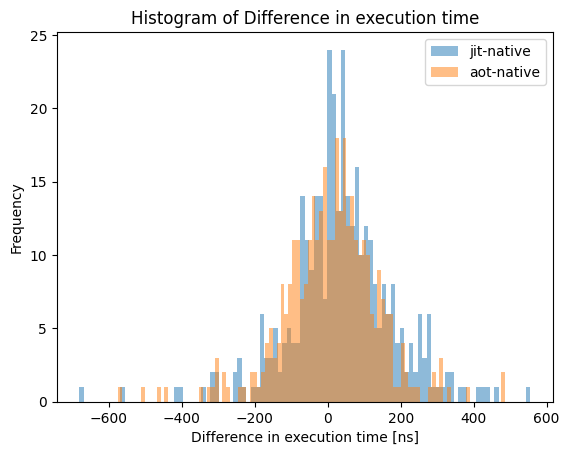

In [148]:
import matplotlib.pyplot as plt


jit_diff = (df_wide['jit'] - df_wide['native']) \
    .loc[lambda x: np.abs(stats.zscore(x)) < 2]
aot_diff = (df_wide['aot'] - df_wide['native']) \
    .loc[lambda x: np.abs(stats.zscore(x)) < 2]

plt.hist(jit_diff, bins=100, alpha=0.5, label='jit-native')
plt.hist(aot_diff, bins=100, alpha=0.5, label='aot-native')

plt.xlabel('Difference in execution time [ns]')
plt.ylabel('Frequency')
plt.title('Histogram of Difference in execution time')
plt.legend()

plt.show()